Link to colab: https://colab.research.google.com/drive/1RewRDUoqP8CYL0BWwm2yGj9-Zdy3-GMS?usp=sharing

In [ ]:
# !wget -O boards_ccrl_1of4.tar 'https://drive.google.com/u/0/uc?id=1wjQfjg8Wee-jVY0gb5L_XXpxCFnc3l_P&confirm=t'
# !tar -xf boards_ccrl_1of4.tar

# !wget -O boards_ccrl_2of4.tar 'https://drive.google.com/u/0/uc?id=1WPJgujT75pQFi-WrI2sZIemBBuPJjZSd&confirm=t'
# !tar -xf boards_ccrl_2of4.tar

!wget -O boards_ccrl_3of4.tar 'https://drive.google.com/u/0/uc?id=1CMDXA7OHmK-ZzLkhXV372bV5keVutFeZ&confirm=t'
!tar -xf boards_ccrl_3of4.tar

# !wget -O boards_ccrl_4of4.tar 'https://drive.google.com/u/0/uc?id=1-6VPabZRFnvz-aHJ43TAMuufSIuh4-d4&confirm=t'
# !tar -xf boards_ccrl_4of4.tar

!wget -O boards_hq_75k.tar 'https://drive.google.com/u/0/uc?id=1pRSmkge5DHocNz3rZCjFek38YFO8-Ze5&confirm=t'
!tar -xf boards_hq_75k.tar

!mv boards_ccrl data_ccrl
!mv boards_hq data_human
!pip install chess

--2023-05-30 13:47:05--  https://drive.google.com/u/0/uc?id=1CMDXA7OHmK-ZzLkhXV372bV5keVutFeZ&confirm=t
Resolving drive.google.com (drive.google.com)... 74.125.130.100, 74.125.130.139, 74.125.130.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.130.100|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1CMDXA7OHmK-ZzLkhXV372bV5keVutFeZ&confirm=t [following]
--2023-05-30 13:47:06--  https://drive.google.com/uc?id=1CMDXA7OHmK-ZzLkhXV372bV5keVutFeZ&confirm=t
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3otorrbe1va9ig8vjkdor3fbh94u1nj0/1685454375000/18334911380517025247/*/1CMDXA7OHmK-ZzLkhXV372bV5keVutFeZ?uuid=fe18d19b-4154-43a8-b4dd-1be8b71dd745 [following]
--2023-05-30 13:47:07--  https://doc-0g-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7

In [ ]:
#@title Setup - Get ChessGNN repo (wait until session restarts)
def get_repo_and_install():
    import subprocess

    assert subprocess.getstatusoutput(f"git clone --depth=1 https://github.com/marcinz99/ChessGNN.git")[0] == 0
    assert subprocess.getstatusoutput(f"pip install -e ChessGNN/")[0] == 0
    exit()

get_repo_and_install()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import subprocess
import chess
import os
import gc
import itertools
from tensorflow.data import Dataset
from chessgnn.graphchess.data_ingestion import get_dataset, select_targets, get_squarewise_features, prepare_features
from chessgnn.graphchess.architecture import input_block, full_block, regular_mlp_head, softmax_mlp_head
from chessgnn.graphchess.helpers import load_model

pd.set_option('display.max_columns', None)
plt.rcParams['figure.dpi'] = 72
DRIVE_PATH = "/content/drive/MyDrive/Praca magisterska/Colabs 4 - Final work/Models{}/"

def run_cmd(cmd):
    subprocess.check_output([cmd], shell=True)

[0.98       0.974375   0.95750004 0.929375   0.89       0.839375
 0.77750003 0.70437497 0.62       0.52437496 0.41750002 0.29937494
 0.16999996 0.02937496 0.         0.        ]


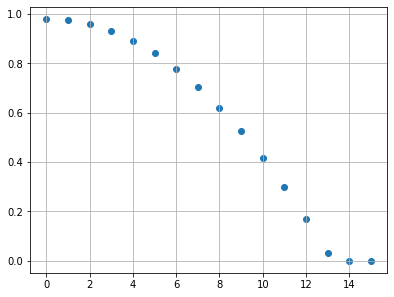

In [ ]:
@tf.function
def filter_by_ply_counts_1(x):
    return tf.maximum(0.0, 0.98 - tf.pow(0.075 * tf.cast(x, dtype=tf.float32), 2))


plt.scatter(np.arange(16), filter_by_ply_counts_1(np.arange(16)))
plt.grid()
print(filter_by_ply_counts_1(np.arange(16)).numpy())

[0.9534931  0.77503383 0.6093499  0.45751506 0.3209312  0.2015413
 0.10231093 0.02870496 0.         0.        ]


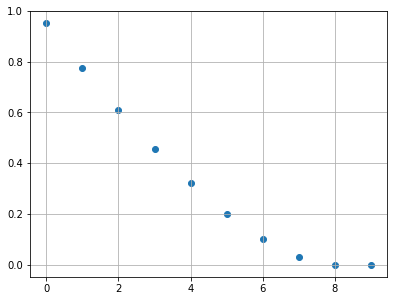

In [ ]:
@tf.function
def filter_by_ply_counts_2(x):
    return tf.pow(tf.maximum(8 - tf.cast(x, dtype=tf.float32) - 0.25, 0) / 8, 1.5)


plt.scatter(np.arange(10), filter_by_ply_counts_2(np.arange(10)))
plt.grid()
print(filter_by_ply_counts_2(np.arange(10)).numpy())

In [ ]:
def filter_by_game_stage_open(ply, piece_track):
    return ply <= 16

def filter_by_game_stage_mid(ply, piece_track):
    return tf.logical_and(ply > 16, tf.reduce_sum(tf.where(piece_track > 0, 1, 0)) > 14)

def filter_by_game_stage_end(ply, piece_track):
    return tf.reduce_sum(tf.where(piece_track > 0, 1, 0)) <= 14

In [ ]:
def evaluate_under_training_routine(model, data_dir, set_num, targets, n_sample, filter_openings=None, filter_game_stage=None, drop_duplicates=0):
    data_path = f'{data_dir}/boards_{(set_num - 1) * 2500 :0>7}.parquet'
    print(f"Set {set_num} (reading games from: {data_path})\n")

    if drop_duplicates > 0:
        ds = get_dataset(data_file_path=data_path, shuffle=True, drop_duplicates=drop_duplicates)
    else:
        ds = get_dataset(data_file_path=data_path, shuffle=True)
        if filter_openings:
            ds = ds.filter(lambda x: filter_openings(x['ply_counter']) < tf.random.uniform([]))

    if filter_game_stage:
        ds = ds.filter(lambda x: filter_game_stage(x['ply_counter'], x['piece_tracking']))

    ds = ds.map(prepare_features)
    ds = ds.batch(1)

    history = model.fit((
        ds
        .map(select_targets(
            input_list=['pos_feats', 'glob_feats', 'coo_graph', 'legal_moves'],
            target_list=targets))
        .take(n_sample)
        .prefetch(100)
    ))
    gc.collect()

    return pd.DataFrame(history.history)

In [ ]:
def prepare_model(model):
    model.trainable = False
    model = tf.keras.models.Model(
        inputs={
            'pos_feats': model.get_layer('pos_feats_input').output,
            'glob_feats': model.get_layer('glob_feats_input').output,
            'coo_graph': model.get_layer('coo_graph_input').output,
            'legal_moves': model.get_layer('legal_moves_input').output,
        },
        outputs={
            'next_move': model.get_layer('next_move').output,
            'final_result': model.get_layer('final_result').output,
        },
    )
    model.compile(
        loss={
            'next_move': 'categorical_crossentropy',
            'final_result': 'categorical_crossentropy',
        },
        optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6),
        metrics={
            'next_move': [
                tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='top_1_accuracy'),
                tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
                tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
                tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
                tf.keras.metrics.TopKCategoricalAccuracy(k=10, name='top_10_accuracy'),
            ],
            'final_result': ['accuracy'],
        },
    )
    return model

# CCRL-trained model, 100 epochs

In [ ]:
PATH_1 = DRIVE_PATH.format('')

model_ver = 100
run_cmd(f'cp "{PATH_1}graphchess_{model_ver}.h5" .')
model_1 = prepare_model(load_model(f"graphchess_{model_ver}.h5"))

## Consistency with human data

In [ ]:
stats_1h = pd.DataFrame()
data_dir = 'data_human'
set_nos = [1, 2, 3, 4, 5]
n_sample = 2500

In [ ]:
stats = pd.DataFrame()
print("All stages\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_1, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=2 * n_sample)
    df['dataset'] = data_dir
    df['stage'] = 'all'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_1h = pd.concat([stats_1h, stats], axis='rows').reset_index(drop=True)

All stages

Set 1 (reading games from: data_human/boards_0000000.parquet)

5000/5000 [==============================] - 178s 32ms/step - loss: 3.6920 - final_result_loss: 1.1721 - next_move_loss: 2.5198 - final_result_accuracy: 0.4076 - next_move_top_1_accuracy: 0.2856 - next_move_top_2_accuracy: 0.4160 - next_move_top_3_accuracy: 0.5008 - next_move_top_5_accuracy: 0.6126 - next_move_top_10_accuracy: 0.7848

Set 2 (reading games from: data_human/boards_0002500.parquet)

5000/5000 [==============================] - 160s 32ms/step - loss: 3.7327 - final_result_loss: 1.2063 - next_move_loss: 2.5264 - final_result_accuracy: 0.3888 - next_move_top_1_accuracy: 0.2852 - next_move_top_2_accuracy: 0.4162 - next_move_top_3_accuracy: 0.4940 - next_move_top_5_accuracy: 0.6084 - next_move_top_10_accuracy: 0.7840

Set 3 (reading games from: data_human/boards_0005000.parquet)

5000/5000 [==============================] - 162s 32ms/step - loss: 3.7117 - final_result_loss: 1.1986 - next_move_loss: 2.51

In [ ]:
stats = pd.DataFrame()
print("Openings\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_1, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=n_sample, filter_game_stage=filter_by_game_stage_open)
    df['dataset'] = data_dir
    df['stage'] = 'opening'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_1h = pd.concat([stats_1h, stats], axis='rows').reset_index(drop=True)

Openings

Set 1 (reading games from: data_human/boards_0000000.parquet)

2500/2500 [==============================] - 155s 62ms/step - loss: 3.3725 - final_result_loss: 1.2152 - next_move_loss: 2.1573 - final_result_accuracy: 0.3932 - next_move_top_1_accuracy: 0.3620 - next_move_top_2_accuracy: 0.5284 - next_move_top_3_accuracy: 0.6292 - next_move_top_5_accuracy: 0.7476 - next_move_top_10_accuracy: 0.9012

Set 2 (reading games from: data_human/boards_0002500.parquet)

2500/2500 [==============================] - 153s 61ms/step - loss: 3.3934 - final_result_loss: 1.2654 - next_move_loss: 2.1280 - final_result_accuracy: 0.3616 - next_move_top_1_accuracy: 0.3608 - next_move_top_2_accuracy: 0.5180 - next_move_top_3_accuracy: 0.6320 - next_move_top_5_accuracy: 0.7488 - next_move_top_10_accuracy: 0.9168

Set 3 (reading games from: data_human/boards_0005000.parquet)

2500/2500 [==============================] - 151s 60ms/step - loss: 3.4007 - final_result_loss: 1.2431 - next_move_loss: 2.1576

In [ ]:
stats = pd.DataFrame()
print("Midgame\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_1, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=n_sample, filter_game_stage=filter_by_game_stage_mid)
    df['dataset'] = data_dir
    df['stage'] = 'midgame'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_1h = pd.concat([stats_1h, stats], axis='rows').reset_index(drop=True)

Midgame

Set 1 (reading games from: data_human/boards_0000000.parquet)

2500/2500 [==============================] - 87s 35ms/step - loss: 3.9007 - final_result_loss: 1.1914 - next_move_loss: 2.7093 - final_result_accuracy: 0.3904 - next_move_top_1_accuracy: 0.2548 - next_move_top_2_accuracy: 0.3764 - next_move_top_3_accuracy: 0.4576 - next_move_top_5_accuracy: 0.5624 - next_move_top_10_accuracy: 0.7292

Set 2 (reading games from: data_human/boards_0002500.parquet)

2500/2500 [==============================] - 89s 35ms/step - loss: 3.9685 - final_result_loss: 1.2255 - next_move_loss: 2.7430 - final_result_accuracy: 0.3652 - next_move_top_1_accuracy: 0.2472 - next_move_top_2_accuracy: 0.3572 - next_move_top_3_accuracy: 0.4368 - next_move_top_5_accuracy: 0.5548 - next_move_top_10_accuracy: 0.7116

Set 3 (reading games from: data_human/boards_0005000.parquet)

2500/2500 [==============================] - 87s 34ms/step - loss: 3.9372 - final_result_loss: 1.2264 - next_move_loss: 2.7108 - f

In [ ]:
stats = pd.DataFrame()
print("Endgame\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_1, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=n_sample, filter_game_stage=filter_by_game_stage_end)
    df['dataset'] = data_dir
    df['stage'] = 'endgame'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_1h = pd.concat([stats_1h, stats], axis='rows').reset_index(drop=True)

Endgame

Set 1 (reading games from: data_human/boards_0000000.parquet)

2500/2500 [==============================] - 217s 87ms/step - loss: 3.1578 - final_result_loss: 0.9117 - next_move_loss: 2.2460 - final_result_accuracy: 0.6028 - next_move_top_1_accuracy: 0.2988 - next_move_top_2_accuracy: 0.4548 - next_move_top_3_accuracy: 0.5476 - next_move_top_5_accuracy: 0.6708 - next_move_top_10_accuracy: 0.8384

Set 2 (reading games from: data_human/boards_0002500.parquet)

2500/2500 [==============================] - 242s 96ms/step - loss: 3.1414 - final_result_loss: 0.8944 - next_move_loss: 2.2470 - final_result_accuracy: 0.6016 - next_move_top_1_accuracy: 0.3032 - next_move_top_2_accuracy: 0.4348 - next_move_top_3_accuracy: 0.5300 - next_move_top_5_accuracy: 0.6612 - next_move_top_10_accuracy: 0.8476

Set 3 (reading games from: data_human/boards_0005000.parquet)

2500/2500 [==============================] - 227s 90ms/step - loss: 3.1478 - final_result_loss: 0.8900 - next_move_loss: 2.2578 

In [ ]:
display(stats_1h)

stats_1h.to_parquet('stats_human.parquet')
run_cmd(f'cp stats_human.parquet "{PATH_1}"')

,loss,final_result_loss,next_move_loss,final_result_accuracy,next_move_top_1_accuracy,next_move_top_2_accuracy,next_move_top_3_accuracy,next_move_top_5_accuracy,next_move_top_10_accuracy,dataset,stage,set_no
0,3.691956,1.172146,2.519814,0.4076,0.2856,0.4160,0.5008,0.6126,0.7848,data_human,all,1
1,3.732684,1.206303,2.526377,0.3888,0.2852,0.4162,0.4940,0.6084,0.7840,data_human,all,2
2,3.711731,1.198552,2.513177,0.3830,0.2832,0.4146,0.5034,0.6182,0.7896,data_human,all,3
3,3.687764,1.175350,2.512419,0.4104,0.2826,0.4142,0.5000,0.6186,0.7860,data_human,all,4
4,3.691736,1.191298,2.500432,0.4028,0.2896,0.4178,0.5032,0.6200,0.7858,data_human,all,5
5,3.372525,1.215203,2.157324,0.3932,0.3620,0.5284,0.6292,0.7476,0.9012,data_human,opening,1
6,3.393427,1.265422,2.128009,0.3616,0.3608,0.5180,0.6320,0.7488,0.9168,data_human,opening,2
7,3.400659,1.243090,2.157568,0.3740,0.3572,0.5112,0.6168,0.7428,0.9100,data_human,opening,3
8,3.394446,1.244373,2.150073,0.3772,0.3588,0.5140,0.6292,0.7512,0.9080,data_human,opening,4
9,3.388724,1.244468,2.144256,0.3792,0.3548,0.5212,0.6296,0.7456,0.9072,data_human,opening,5


## Consistency with other CCRL data

In [ ]:
stats_1c = pd.DataFrame()
data_dir = 'data_ccrl'
set_nos = [121, 122, 123, 124, 125]
n_sample = 2500

In [ ]:
stats = pd.DataFrame()
print("All stages\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_1, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=2 * n_sample)
    df['dataset'] = data_dir
    df['stage'] = 'all'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_1c = pd.concat([stats_1c, stats], axis='rows').reset_index(drop=True)

All stages

Set 121 (reading games from: data_ccrl/boards_0300000.parquet)

5000/5000 [==============================] - 160s 32ms/step - loss: 3.3970 - final_result_loss: 0.8209 - next_move_loss: 2.5761 - final_result_accuracy: 0.6490 - next_move_top_1_accuracy: 0.2408 - next_move_top_2_accuracy: 0.3622 - next_move_top_3_accuracy: 0.4492 - next_move_top_5_accuracy: 0.5796 - next_move_top_10_accuracy: 0.7764

Set 122 (reading games from: data_ccrl/boards_0302500.parquet)

5000/5000 [==============================] - 162s 32ms/step - loss: 3.4452 - final_result_loss: 0.8492 - next_move_loss: 2.5960 - final_result_accuracy: 0.6282 - next_move_top_1_accuracy: 0.2400 - next_move_top_2_accuracy: 0.3656 - next_move_top_3_accuracy: 0.4520 - next_move_top_5_accuracy: 0.5752 - next_move_top_10_accuracy: 0.7674

Set 123 (reading games from: data_ccrl/boards_0305000.parquet)

5000/5000 [==============================] - 164s 33ms/step - loss: 3.4187 - final_result_loss: 0.8385 - next_move_loss: 2

In [ ]:
stats = pd.DataFrame()
print("Openings\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_1, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=n_sample, filter_game_stage=filter_by_game_stage_open)
    df['dataset'] = data_dir
    df['stage'] = 'opening'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_1c = pd.concat([stats_1c, stats], axis='rows').reset_index(drop=True)

Openings

Set 121 (reading games from: data_ccrl/boards_0300000.parquet)

2500/2500 [==============================] - 240s 95ms/step - loss: 3.1024 - final_result_loss: 0.9269 - next_move_loss: 2.1755 - final_result_accuracy: 0.6052 - next_move_top_1_accuracy: 0.3388 - next_move_top_2_accuracy: 0.5012 - next_move_top_3_accuracy: 0.6092 - next_move_top_5_accuracy: 0.7344 - next_move_top_10_accuracy: 0.9132

Set 122 (reading games from: data_ccrl/boards_0302500.parquet)

2500/2500 [==============================] - 235s 93ms/step - loss: 3.1118 - final_result_loss: 0.9671 - next_move_loss: 2.1447 - final_result_accuracy: 0.5828 - next_move_top_1_accuracy: 0.3552 - next_move_top_2_accuracy: 0.5156 - next_move_top_3_accuracy: 0.6204 - next_move_top_5_accuracy: 0.7372 - next_move_top_10_accuracy: 0.9132

Set 123 (reading games from: data_ccrl/boards_0305000.parquet)

2500/2500 [==============================] - 238s 94ms/step - loss: 3.0361 - final_result_loss: 0.9308 - next_move_loss: 2.1

In [ ]:
stats = pd.DataFrame()
print("Midgame\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_1, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=n_sample, filter_game_stage=filter_by_game_stage_mid)
    df['dataset'] = data_dir
    df['stage'] = 'midgame'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_1c = pd.concat([stats_1c, stats], axis='rows').reset_index(drop=True)

Midgame

Set 121 (reading games from: data_ccrl/boards_0300000.parquet)

2500/2500 [==============================] - 89s 35ms/step - loss: 3.6663 - final_result_loss: 0.9201 - next_move_loss: 2.7462 - final_result_accuracy: 0.5872 - next_move_top_1_accuracy: 0.2260 - next_move_top_2_accuracy: 0.3356 - next_move_top_3_accuracy: 0.4152 - next_move_top_5_accuracy: 0.5360 - next_move_top_10_accuracy: 0.7372

Set 122 (reading games from: data_ccrl/boards_0302500.parquet)

2500/2500 [==============================] - 89s 35ms/step - loss: 3.7911 - final_result_loss: 0.9500 - next_move_loss: 2.8411 - final_result_accuracy: 0.5612 - next_move_top_1_accuracy: 0.2136 - next_move_top_2_accuracy: 0.3192 - next_move_top_3_accuracy: 0.3868 - next_move_top_5_accuracy: 0.4988 - next_move_top_10_accuracy: 0.6900

Set 123 (reading games from: data_ccrl/boards_0305000.parquet)

2500/2500 [==============================] - 89s 35ms/step - loss: 3.7124 - final_result_loss: 0.9006 - next_move_loss: 2.8118 

In [ ]:
stats = pd.DataFrame()
print("Endgame\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_1, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=n_sample, filter_game_stage=filter_by_game_stage_end)
    df['dataset'] = data_dir
    df['stage'] = 'endgame'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_1c = pd.concat([stats_1c, stats], axis='rows').reset_index(drop=True)

Endgame

Set 121 (reading games from: data_ccrl/boards_0300000.parquet)

2500/2500 [==============================] - 126s 50ms/step - loss: 2.9823 - final_result_loss: 0.6171 - next_move_loss: 2.3651 - final_result_accuracy: 0.7528 - next_move_top_1_accuracy: 0.2304 - next_move_top_2_accuracy: 0.3764 - next_move_top_3_accuracy: 0.4808 - next_move_top_5_accuracy: 0.6268 - next_move_top_10_accuracy: 0.8496

Set 122 (reading games from: data_ccrl/boards_0302500.parquet)

2500/2500 [==============================] - 122s 48ms/step - loss: 3.0156 - final_result_loss: 0.6403 - next_move_loss: 2.3753 - final_result_accuracy: 0.7296 - next_move_top_1_accuracy: 0.2408 - next_move_top_2_accuracy: 0.3700 - next_move_top_3_accuracy: 0.4668 - next_move_top_5_accuracy: 0.6204 - next_move_top_10_accuracy: 0.8400

Set 123 (reading games from: data_ccrl/boards_0305000.parquet)

2500/2500 [==============================] - 124s 49ms/step - loss: 3.0331 - final_result_loss: 0.6395 - next_move_loss: 2.39

In [ ]:
display(stats_1c)

stats_1c.to_parquet('stats_ccrl.parquet')
run_cmd(f'cp stats_ccrl.parquet "{PATH_1}"')

,loss,final_result_loss,next_move_loss,final_result_accuracy,next_move_top_1_accuracy,next_move_top_2_accuracy,next_move_top_3_accuracy,next_move_top_5_accuracy,next_move_top_10_accuracy,dataset,stage,set_no
0,3.396995,0.820885,2.576113,0.6490,0.2408,0.3622,0.4492,0.5796,0.7764,data_ccrl,all,121
1,3.445248,0.849215,2.596028,0.6282,0.2400,0.3656,0.4520,0.5752,0.7674,data_ccrl,all,122
2,3.418666,0.838523,2.580144,0.6338,0.2478,0.3756,0.4564,0.5812,0.7708,data_ccrl,all,123
3,3.446016,0.840112,2.605900,0.6298,0.2370,0.3618,0.4438,0.5676,0.7666,data_ccrl,all,124
4,3.453954,0.857986,2.595964,0.6092,0.2414,0.3618,0.4510,0.5782,0.7680,data_ccrl,all,125
5,3.102374,0.926920,2.175453,0.6052,0.3388,0.5012,0.6092,0.7344,0.9132,data_ccrl,opening,121
6,3.111827,0.967142,2.144682,0.5828,0.3552,0.5156,0.6204,0.7372,0.9132,data_ccrl,opening,122
7,3.036073,0.930778,2.105299,0.6032,0.3548,0.5236,0.6432,0.7532,0.9244,data_ccrl,opening,123
8,3.064160,0.940647,2.123518,0.5956,0.3564,0.5244,0.6256,0.7472,0.9132,data_ccrl,opening,124
9,3.089319,0.984487,2.104829,0.5560,0.3704,0.5240,0.6472,0.7592,0.9228,data_ccrl,opening,125


# Same + fine-tuned on human, 30 epochs

In [ ]:
PATH_2 = DRIVE_PATH.format('2')

model_ver = 30
run_cmd(f'cp "{PATH_2}graphchess_{model_ver}.h5" .')
model_2 = prepare_model(load_model(f"graphchess_{model_ver}.h5"))

## Consistency with human data

In [ ]:
stats_2h = pd.DataFrame()
data_dir = 'data_human'
set_nos = [1, 2, 3, 4, 5]
n_sample = 2500

In [ ]:
stats = pd.DataFrame()
print("All stages\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_2, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=2 * n_sample)
    df['dataset'] = data_dir
    df['stage'] = 'all'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_2h = pd.concat([stats_2h, stats], axis='rows').reset_index(drop=True)

All stages

Set 1 (reading games from: data_human/boards_0000000.parquet)

5000/5000 [==============================] - 217s 38ms/step - loss: 3.3255 - final_result_loss: 0.9421 - next_move_loss: 2.3834 - final_result_accuracy: 0.5390 - next_move_top_1_accuracy: 0.3076 - next_move_top_2_accuracy: 0.4534 - next_move_top_3_accuracy: 0.5410 - next_move_top_5_accuracy: 0.6612 - next_move_top_10_accuracy: 0.8082

Set 2 (reading games from: data_human/boards_0002500.parquet)

5000/5000 [==============================] - 203s 40ms/step - loss: 3.3142 - final_result_loss: 0.9486 - next_move_loss: 2.3656 - final_result_accuracy: 0.5272 - next_move_top_1_accuracy: 0.3128 - next_move_top_2_accuracy: 0.4582 - next_move_top_3_accuracy: 0.5472 - next_move_top_5_accuracy: 0.6582 - next_move_top_10_accuracy: 0.8270

Set 3 (reading games from: data_human/boards_0005000.parquet)

5000/5000 [==============================] - 187s 37ms/step - loss: 3.2870 - final_result_loss: 0.9322 - next_move_loss: 2.35

In [ ]:
stats = pd.DataFrame()
print("Openings\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_2, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=n_sample, filter_game_stage=filter_by_game_stage_open)
    df['dataset'] = data_dir
    df['stage'] = 'opening'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_2h = pd.concat([stats_2h, stats], axis='rows').reset_index(drop=True)

Openings

Set 1 (reading games from: data_human/boards_0000000.parquet)

2500/2500 [==============================] - 172s 68ms/step - loss: 2.9064 - final_result_loss: 1.0732 - next_move_loss: 1.8332 - final_result_accuracy: 0.4140 - next_move_top_1_accuracy: 0.4528 - next_move_top_2_accuracy: 0.6284 - next_move_top_3_accuracy: 0.7248 - next_move_top_5_accuracy: 0.8364 - next_move_top_10_accuracy: 0.9392

Set 2 (reading games from: data_human/boards_0002500.parquet)

2500/2500 [==============================] - 172s 68ms/step - loss: 2.9397 - final_result_loss: 1.0660 - next_move_loss: 1.8737 - final_result_accuracy: 0.4228 - next_move_top_1_accuracy: 0.4252 - next_move_top_2_accuracy: 0.6032 - next_move_top_3_accuracy: 0.7164 - next_move_top_5_accuracy: 0.8356 - next_move_top_10_accuracy: 0.9436

Set 3 (reading games from: data_human/boards_0005000.parquet)

2500/2500 [==============================] - 169s 67ms/step - loss: 2.9138 - final_result_loss: 1.0743 - next_move_loss: 1.8395

In [ ]:
stats = pd.DataFrame()
print("Midgame\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_2, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=n_sample, filter_game_stage=filter_by_game_stage_mid)
    df['dataset'] = data_dir
    df['stage'] = 'midgame'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_2h = pd.concat([stats_2h, stats], axis='rows').reset_index(drop=True)

Midgame

Set 1 (reading games from: data_human/boards_0000000.parquet)

2500/2500 [==============================] - 102s 40ms/step - loss: 3.5409 - final_result_loss: 0.9733 - next_move_loss: 2.5676 - final_result_accuracy: 0.5056 - next_move_top_1_accuracy: 0.2796 - next_move_top_2_accuracy: 0.4004 - next_move_top_3_accuracy: 0.4880 - next_move_top_5_accuracy: 0.5972 - next_move_top_10_accuracy: 0.7744

Set 2 (reading games from: data_human/boards_0002500.parquet)

2500/2500 [==============================] - 99s 39ms/step - loss: 3.5237 - final_result_loss: 0.9629 - next_move_loss: 2.5608 - final_result_accuracy: 0.5356 - next_move_top_1_accuracy: 0.2708 - next_move_top_2_accuracy: 0.4208 - next_move_top_3_accuracy: 0.4948 - next_move_top_5_accuracy: 0.6012 - next_move_top_10_accuracy: 0.7788

Set 3 (reading games from: data_human/boards_0005000.parquet)

2500/2500 [==============================] - 99s 39ms/step - loss: 3.5228 - final_result_loss: 0.9532 - next_move_loss: 2.5696 - 

In [ ]:
stats = pd.DataFrame()
print("Endgame\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_2, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=n_sample, filter_game_stage=filter_by_game_stage_end)
    df['dataset'] = data_dir
    df['stage'] = 'endgame'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_2h = pd.concat([stats_2h, stats], axis='rows').reset_index(drop=True)

Endgame

Set 1 (reading games from: data_human/boards_0000000.parquet)

2500/2500 [==============================] - 237s 94ms/step - loss: 2.8077 - final_result_loss: 0.6641 - next_move_loss: 2.1436 - final_result_accuracy: 0.7196 - next_move_top_1_accuracy: 0.3088 - next_move_top_2_accuracy: 0.4720 - next_move_top_3_accuracy: 0.5708 - next_move_top_5_accuracy: 0.7064 - next_move_top_10_accuracy: 0.8780

Set 2 (reading games from: data_human/boards_0002500.parquet)

2500/2500 [==============================] - 264s 105ms/step - loss: 2.8729 - final_result_loss: 0.7061 - next_move_loss: 2.1668 - final_result_accuracy: 0.6860 - next_move_top_1_accuracy: 0.3172 - next_move_top_2_accuracy: 0.4584 - next_move_top_3_accuracy: 0.5484 - next_move_top_5_accuracy: 0.6772 - next_move_top_10_accuracy: 0.8608

Set 3 (reading games from: data_human/boards_0005000.parquet)

2500/2500 [==============================] - 255s 101ms/step - loss: 2.8454 - final_result_loss: 0.6819 - next_move_loss: 2.163

In [ ]:
display(stats_2h)

stats_2h.to_parquet('stats_human.parquet')
run_cmd(f'cp stats_human.parquet "{PATH_2}"')

,loss,final_result_loss,next_move_loss,final_result_accuracy,next_move_top_1_accuracy,next_move_top_2_accuracy,next_move_top_3_accuracy,next_move_top_5_accuracy,next_move_top_10_accuracy,dataset,stage,set_no
0,3.325521,0.942087,2.383435,0.5390,0.3076,0.4534,0.5410,0.6612,0.8082,data_human,all,1
1,3.314222,0.948582,2.365645,0.5272,0.3128,0.4582,0.5472,0.6582,0.8270,data_human,all,2
2,3.287017,0.932188,2.354829,0.5358,0.3092,0.4570,0.5462,0.6602,0.8268,data_human,all,3
3,3.342154,0.955599,2.386551,0.5128,0.3034,0.4566,0.5474,0.6582,0.8208,data_human,all,4
4,3.340896,0.964027,2.376864,0.5104,0.3190,0.4584,0.5358,0.6564,0.8166,data_human,all,5
5,2.906395,1.073195,1.833200,0.4140,0.4528,0.6284,0.7248,0.8364,0.9392,data_human,opening,1
6,2.939720,1.066032,1.873693,0.4228,0.4252,0.6032,0.7164,0.8356,0.9436,data_human,opening,2
7,2.913772,1.074257,1.839517,0.4248,0.4464,0.6196,0.7232,0.8360,0.9340,data_human,opening,3
8,2.916759,1.069741,1.847023,0.4260,0.4400,0.6140,0.7128,0.8312,0.9360,data_human,opening,4
9,2.894473,1.073212,1.821264,0.4184,0.4468,0.6284,0.7328,0.8400,0.9440,data_human,opening,5


## Consistency with other CCRL data

In [ ]:
stats_2c = pd.DataFrame()
data_dir = 'data_ccrl'
set_nos = [121, 122, 123, 124, 125]
n_sample = 2500

In [ ]:
stats = pd.DataFrame()
print("All stages\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_2, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=2 * n_sample)
    df['dataset'] = data_dir
    df['stage'] = 'all'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_2c = pd.concat([stats_2c, stats], axis='rows').reset_index(drop=True)

All stages

Set 121 (reading games from: data_ccrl/boards_0300000.parquet)

5000/5000 [==============================] - 187s 37ms/step - loss: 3.4905 - final_result_loss: 0.9354 - next_move_loss: 2.5551 - final_result_accuracy: 0.5486 - next_move_top_1_accuracy: 0.2436 - next_move_top_2_accuracy: 0.3666 - next_move_top_3_accuracy: 0.4600 - next_move_top_5_accuracy: 0.5882 - next_move_top_10_accuracy: 0.7844

Set 122 (reading games from: data_ccrl/boards_0302500.parquet)

5000/5000 [==============================] - 187s 37ms/step - loss: 3.4554 - final_result_loss: 0.9510 - next_move_loss: 2.5044 - final_result_accuracy: 0.5412 - next_move_top_1_accuracy: 0.2552 - next_move_top_2_accuracy: 0.3880 - next_move_top_3_accuracy: 0.4818 - next_move_top_5_accuracy: 0.6130 - next_move_top_10_accuracy: 0.7936

Set 123 (reading games from: data_ccrl/boards_0305000.parquet)

5000/5000 [==============================] - 187s 37ms/step - loss: 3.4654 - final_result_loss: 0.9451 - next_move_loss: 2

In [ ]:
stats = pd.DataFrame()
print("Openings\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_2, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=n_sample, filter_game_stage=filter_by_game_stage_open)
    df['dataset'] = data_dir
    df['stage'] = 'opening'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_2c = pd.concat([stats_2c, stats], axis='rows').reset_index(drop=True)

Openings

Set 121 (reading games from: data_ccrl/boards_0300000.parquet)

2500/2500 [==============================] - 275s 109ms/step - loss: 2.9510 - final_result_loss: 1.0526 - next_move_loss: 1.8984 - final_result_accuracy: 0.4804 - next_move_top_1_accuracy: 0.4200 - next_move_top_2_accuracy: 0.6024 - next_move_top_3_accuracy: 0.7096 - next_move_top_5_accuracy: 0.8288 - next_move_top_10_accuracy: 0.9428

Set 122 (reading games from: data_ccrl/boards_0302500.parquet)

2500/2500 [==============================] - 272s 108ms/step - loss: 2.9469 - final_result_loss: 1.0591 - next_move_loss: 1.8878 - final_result_accuracy: 0.4780 - next_move_top_1_accuracy: 0.4084 - next_move_top_2_accuracy: 0.6056 - next_move_top_3_accuracy: 0.7236 - next_move_top_5_accuracy: 0.8376 - next_move_top_10_accuracy: 0.9440

Set 123 (reading games from: data_ccrl/boards_0305000.parquet)

2500/2500 [==============================] - 274s 109ms/step - loss: 2.9499 - final_result_loss: 1.0607 - next_move_loss: 

In [ ]:
stats = pd.DataFrame()
print("Midgame\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_2, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=n_sample, filter_game_stage=filter_by_game_stage_mid)
    df['dataset'] = data_dir
    df['stage'] = 'midgame'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_2c = pd.concat([stats_2c, stats], axis='rows').reset_index(drop=True)

Midgame

Set 121 (reading games from: data_ccrl/boards_0300000.parquet)

2500/2500 [==============================] - 103s 40ms/step - loss: 3.8520 - final_result_loss: 1.0416 - next_move_loss: 2.8104 - final_result_accuracy: 0.4860 - next_move_top_1_accuracy: 0.2120 - next_move_top_2_accuracy: 0.3208 - next_move_top_3_accuracy: 0.4036 - next_move_top_5_accuracy: 0.5196 - next_move_top_10_accuracy: 0.7224

Set 122 (reading games from: data_ccrl/boards_0302500.parquet)

2500/2500 [==============================] - 103s 40ms/step - loss: 3.7903 - final_result_loss: 1.0444 - next_move_loss: 2.7458 - final_result_accuracy: 0.4820 - next_move_top_1_accuracy: 0.2288 - next_move_top_2_accuracy: 0.3332 - next_move_top_3_accuracy: 0.4132 - next_move_top_5_accuracy: 0.5340 - next_move_top_10_accuracy: 0.7208

Set 123 (reading games from: data_ccrl/boards_0305000.parquet)

2500/2500 [==============================] - 104s 41ms/step - loss: 3.8318 - final_result_loss: 1.0437 - next_move_loss: 2.78

In [ ]:
stats = pd.DataFrame()
print("Endgame\n")

for set_no in set_nos:
    df = evaluate_under_training_routine(
        model=model_2, data_dir=data_dir, set_num=set_no,
        targets=['next_move', 'final_result'],
        n_sample=n_sample, filter_game_stage=filter_by_game_stage_end)
    df['dataset'] = data_dir
    df['stage'] = 'endgame'
    df['set_no'] = set_no
    stats = pd.concat([stats, df], axis='rows')
    print()

stats_2c = pd.concat([stats_2c, stats], axis='rows').reset_index(drop=True)

Endgame

Set 121 (reading games from: data_ccrl/boards_0300000.parquet)

2500/2500 [==============================] - 145s 57ms/step - loss: 3.0480 - final_result_loss: 0.6647 - next_move_loss: 2.3834 - final_result_accuracy: 0.7264 - next_move_top_1_accuracy: 0.2268 - next_move_top_2_accuracy: 0.3536 - next_move_top_3_accuracy: 0.4560 - next_move_top_5_accuracy: 0.6180 - next_move_top_10_accuracy: 0.8448

Set 122 (reading games from: data_ccrl/boards_0302500.parquet)

2500/2500 [==============================] - 140s 55ms/step - loss: 3.0850 - final_result_loss: 0.6980 - next_move_loss: 2.3870 - final_result_accuracy: 0.6944 - next_move_top_1_accuracy: 0.2340 - next_move_top_2_accuracy: 0.3800 - next_move_top_3_accuracy: 0.4788 - next_move_top_5_accuracy: 0.6240 - next_move_top_10_accuracy: 0.8336

Set 123 (reading games from: data_ccrl/boards_0305000.parquet)

2500/2500 [==============================] - 141s 56ms/step - loss: 3.1078 - final_result_loss: 0.7314 - next_move_loss: 2.37

In [ ]:
display(stats_2c)

stats_2c.to_parquet('stats_ccrl.parquet')
run_cmd(f'cp stats_ccrl.parquet "{PATH_2}"')

,loss,final_result_loss,next_move_loss,final_result_accuracy,next_move_top_1_accuracy,next_move_top_2_accuracy,next_move_top_3_accuracy,next_move_top_5_accuracy,next_move_top_10_accuracy,dataset,stage,set_no
0,3.490468,0.935398,2.555072,0.5486,0.2436,0.3666,0.4600,0.5882,0.7844,data_ccrl,all,121
1,3.455420,0.950994,2.504430,0.5412,0.2552,0.3880,0.4818,0.6130,0.7936,data_ccrl,all,122
2,3.465354,0.945091,2.520260,0.5518,0.2578,0.3920,0.4822,0.5980,0.7828,data_ccrl,all,123
3,3.485798,0.947946,2.537852,0.5408,0.2548,0.3888,0.4730,0.5958,0.7866,data_ccrl,all,124
4,3.466362,0.938904,2.527454,0.5510,0.2574,0.3844,0.4714,0.5934,0.7860,data_ccrl,all,125
5,2.950966,1.052584,1.898380,0.4804,0.4200,0.6024,0.7096,0.8288,0.9428,data_ccrl,opening,121
6,2.946852,1.059071,1.887786,0.4780,0.4084,0.6056,0.7236,0.8376,0.9440,data_ccrl,opening,122
7,2.949883,1.060670,1.889214,0.4584,0.4248,0.6056,0.7176,0.8228,0.9336,data_ccrl,opening,123
8,2.976294,1.059018,1.917276,0.4608,0.4008,0.5956,0.7088,0.8188,0.9364,data_ccrl,opening,124
9,2.960869,1.060131,1.900741,0.4588,0.4256,0.6052,0.7128,0.8192,0.9276,data_ccrl,opening,125
